In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

import collections

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pymc3 as pm

import scipy.stats as stats

from matplotlib.patches import Ellipse
import numpy.random as rnd

In [3]:
a = 3.5        # average morning wait time
b = -1         # average difference afternoon wait time

sigma_a = 1    # std dev in intercepts
sigma_b = 0.5  # std dev in slopes

rho = -0.7     # correlation between intercepts and slopes

# Multivariate normal
Mu = np.array([a, b])

# variance-covariance matrix
Sigma = np.array([
        [sigma_a**2, sigma_a * sigma_b * rho], 
        [sigma_a * sigma_b * rho, sigma_b**2]
    ])

N_cafes = 20
seed = 5

vary_effects = stats.multivariate_normal.rvs(mean=Mu, cov=Sigma, size=N_cafes ,random_state=5)

a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

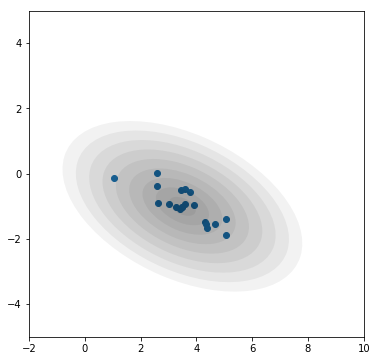

In [4]:
ells = [Ellipse(xy=(a, b), width=sigma_a * i, height=sigma_b * i, angle=340)
        for i in range(10)]

fig, ax = plt.subplots(1,1, figsize=(6, 6))

for e in ells:
    e.set_alpha(0.05)
    e.set_facecolor('k')
    ax.add_artist(e)

ax.scatter(a_cafe, b_cafe)

ax.set_xlim(-2, 10)
ax.set_ylim(-5, 5)

plt.show()

In [5]:
N_visits = 10

afternoon_one = np.ones(N_cafes * N_visits // 2)
afternoon_zero = np.zeros(N_cafes * N_visits // 2)

# Simulating waiting times
cafe_df = pd.DataFrame(vary_effects).rename(columns={0: 'cafe_mu', 1: 'cafe_sigma'})
cafe_df = pd.concat([cafe_df for _ in range(5)]).sort_index()

# mu
morning_mus = cafe_df['cafe_mu'] + cafe_df['cafe_sigma'] * afternoon_zero
aftnoon_mus = cafe_df['cafe_mu'] + cafe_df['cafe_sigma'] * afternoon_one

# variance within cafe
sigma = 0.5 

morning_wait_times = stats.norm.rvs(morning_mus, sigma)
aftnoon_wait_times = stats.norm.rvs(aftnoon_mus, sigma)

wait_df = pd.concat([pd.Series(morning_wait_times), pd.Series(aftnoon_wait_times)], axis=1).set_index(cafe_df.index)#.rename(columns={0: 'morning_wait', 1:'aftnoon_wait'})
wait_df = wait_df.stack().reset_index()
wait_df.columns = ['cafe_id', 'is_afternoon', 'wait_time']



#### 13.1.3 A model that reconstructs the waiting times -- varying slopes

$$W_i \sim Normal(\mu_i, \sigma) $$

$$\mu_i = \alpha_{CAFE[i]} + \beta_{CAFE[i]} * A_i$$

$$
\begin{bmatrix} 
\alpha_{CAFE}\\
\beta_{CAFE}
\end{bmatrix} = MVNormal( \begin{bmatrix} \alpha \\ \beta \end{bmatrix}, \textbf{S})
$$

$$
S = \begin{pmatrix} \sigma_\alpha & 0 \\ 0 & \sigma_\beta\end{pmatrix} 
  * \textbf{R}
  * \begin{pmatrix} \sigma_\alpha & 0 \\ 0 & \sigma_\beta\end{pmatrix} 
$$

$$\alpha \sim Normal(0, 10)$$

$$\beta \sim Normal(0, 10)$$

$$\sigma, \sigma_\alpha, \sigma_\beta \sim HalfCauchy(0, 1)$$

$$ \textbf{R} \sim LKJcorr(2)$$

In [6]:
from theano import tensor as tt

In [7]:
wait_df.head()

,cafe_id,is_afternoon,wait_time
0,0,0,1.846442
1,0,1,2.449724
2,0,0,2.840439
3,0,1,2.685100
4,0,0,3.398257


In [10]:
with pm.Model() as m131:
    
    #alpha = pm.Normal('alpha', mu=0, sd=5, shape=len(d))
    
    alpha = pm.Normal('alpha', 0, 10, shape=N_cafes)
    beta = pm.Normal('beta', 0, 10, shape=N_cafes)
    
    sigma = pm.HalfCauchy('sigma', 1)
    sigmas = pm.HalfCauchy('sigmas', 1, shape=2)
    
    sigma_diag = tt.nlinalg.diag(sigmas)
    
    #R_triu = pm.LKJCorr('R_triu', p = 2, n = 2) 
    nu = pm.Uniform('nu', 0, 5)
    R_triu = pm.LKJCorr('R_triu', nu, 2)
    
    R = pm.Deterministic('R', tt.fill_diagonal(R_triu[np.zeros((2, 2), dtype=np.int64)], 1.))
    cov = pm.Deterministic('cov', tt.nlinalg.matrix_dot(sigma_diag, R, sigma_diag))
    tau = pm.Deterministic('tau', tt.nlinalg.matrix_inverse(cov))

    covariates = pm.MvNormal('mvmu', [alpha, beta], tau, shape=N_cafes)
    mu = covariates[:, 0][wait_df.cafe_id] + covariates[:, 1][wait_df.cafe_id] * wait_df.is_afternoon
    
    waits = pm.Normal('wait', mu, sigma, observed=wait_df.wait_time)
    
    m131_map = pm.find_MAP()
    m131_traces = pm.sample(10000, start=m131_map)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [72]:
pm.trace_to_dataframe(m131_traces)

,R__0_0,R__0_1,R__1_0,R__1_1,sigma_alpha,sigma,sigma_beta,alpha__0,alpha__1,alpha__2,...,beta__15,beta__16,beta__17,beta__18,beta__19,R_triu__0,cov__0_0,cov__0_1,cov__1_0,cov__1_1
0,1.0,0.0,0.0,1.0,1.0,0.493485,1.0,3.18172,1.000125,4.190059,...,-0.757973,-1.38181,-1.112398,-0.222507,-0.425339,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,1.0,0.493485,1.0,3.18172,1.000125,4.190059,...,-0.757973,-1.38181,-1.112398,-0.222507,-0.425339,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,1.0,1.0,0.493485,1.0,3.18172,1.000125,4.190059,...,-0.757973,-1.38181,-1.112398,-0.222507,-0.425339,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,1.0,0.493485,1.0,3.18172,1.000125,4.190059,...,-0.757973,-1.38181,-1.112398,-0.222507,-0.425339,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,1.0,0.493485,1.0,3.18172,1.000125,4.190059,...,-0.757973,-1.38181,-1.112398,-0.222507,-0.425339,0.0,1.0,0.0,0.0,1.0
5,1.0,0.0,0.0,1.0,1.0,0.493485,1.0,3.18172,1.000125,4.190059,...,-0.757973,-1.38181,-1.112398,-0.222507,-0.425339,0.0,1.0,0.0,0.0,1.0
6,1.0,0.0,0.0,1.0,1.0,0.493485,1.0,3.18172,1.000125,4.190059,...,-0.757973,-1.38181,-1.112398,-0.222507,-0.425339,0.0,1.0,0.0,0.0,1.0
7,1.0,0.0,0.0,1.0,1.0,0.493485,1.0,3.18172,1.000125,4.190059,...,-0.757973,-1.38181,-1.112398,-0.222507,-0.425339,0.0,1.0,0.0,0.0,1.0
8,1.0,0.0,0.0,1.0,1.0,0.493485,1.0,3.18172,1.000125,4.190059,...,-0.757973,-1.38181,-1.112398,-0.222507,-0.425339,0.0,1.0,0.0,0.0,1.0
9,1.0,0.0,0.0,1.0,1.0,0.493485,1.0,3.18172,1.000125,4.190059,...,-0.757973,-1.38181,-1.112398,-0.222507,-0.425339,0.0,1.0,0.0,0.0,1.0


### 13.2. Example: Admission decisions and gender

In [6]:
df = pd.read_csv('./rethinking/data/UCBadmit.csv', sep=';')
df['dept_id'] = df['dept'].astype('category').cat.codes
df['is_male'] = (df['applicant.gender'] == 'male').astype(int)
df['applications'] = df['applications'].astype(np.int32)

In [7]:
df

,dept,applicant.gender,admit,reject,applications,dept_id,is_male
1,A,male,512,313,825,0,1
2,A,female,89,19,108,0,0
3,B,male,353,207,560,1,1
4,B,female,17,8,25,1,0
5,C,male,120,205,325,2,1
6,C,female,202,391,593,2,0
7,D,male,138,279,417,3,1
8,D,female,131,244,375,3,0
9,E,male,53,138,191,4,1
10,E,female,94,299,393,4,0


#### 13.2.1 Varying intercepts model

Likelihood: $A_i \sim Binomial(n_i, p_i) $

Linear model: $logit(p_i) = a_{DEPT[i]} + \beta m_i$

Prior for varying intercepts: $a_{DEPT} \sim Normal(\alpha, \sigma)$

Prior for alpha: $\alpha \sim Normal(0, 10)$

Prior for beta: $\beta \sim Normal(0, 1)$

Prior for sigma: $\sigma \sim HalfCauchy(0, 2)$

In [8]:
with pm.Model() as m106:
    
    #alpha = pm.Normal('alpha', mu=0, sd=5, shape=len(d))
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 1)
    sigma = pm.HalfCauchy('sigma', 2)
    
    alpha_dept = pm.Normal('alpha_dept', alpha, sigma, shape=df.dept_id.nunique())
    
    lin = alpha_dept[df['dept_id'].values] + beta * df['is_male']
    p = np.exp(lin) / (1 + np.exp(lin))
    
    admit = pm.Binomial('admit', n=df['applications'].values, p=p, observed=df['admit'])
        
    m106_map = pm.find_MAP()
    m106_traces = pm.sample(10000, start=m106_map)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '30714' (I am process '31279')
100%|██████████| 10000/10000 [00:42<00:00, 237.89it/s]


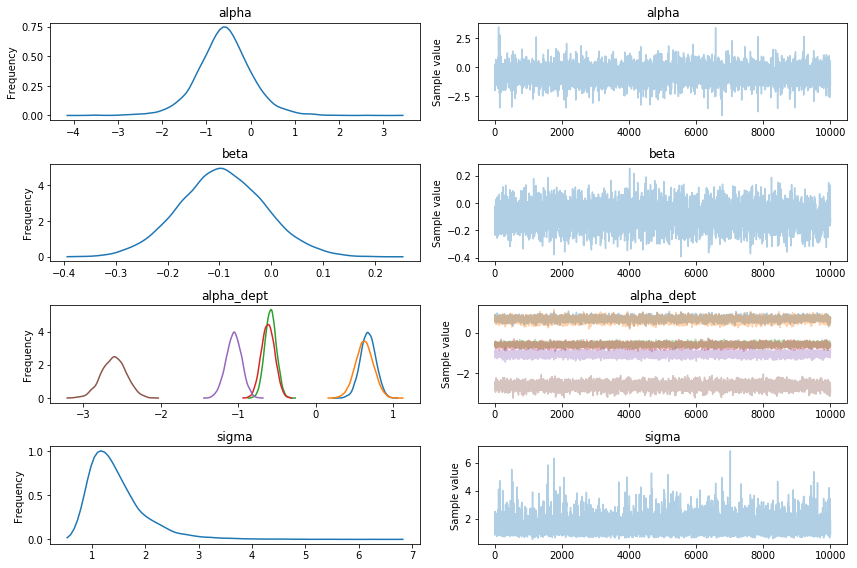

In [9]:
pm.traceplot(m106_traces);

In [14]:
m106_traces_df = pm.trace_to_dataframe(m106_traces)

In [11]:
m106_traces_df.mean()

alpha           -0.598628
beta            -0.094262
alpha_dept__0    0.674179
alpha_dept__1    0.628216
alpha_dept__2   -0.582779
alpha_dept__3   -0.616823
alpha_dept__4   -1.058905
alpha_dept__5   -2.609381
sigma            1.475024
dtype: float64

#### 13.2.2 Varying effects of being male

$$A_i \sim Binomial(n_i, p_i) $$

$$logit(p_i) = \alpha_{DEPT[i]} + \beta_{DEPT[i]} * m_i$$

$$
\begin{bmatrix} 
\alpha_{DEPT}\\
\beta_{DEPT}
\end{bmatrix} = MVNormal( \begin{bmatrix} \alpha \\ \beta \end{bmatrix}, \textbf{S})
$$

$$
S = \begin{pmatrix} \sigma_\alpha & 0 \\ 0 & \sigma_\beta\end{pmatrix} 
  * \textbf{R}
  * \begin{pmatrix} \sigma_\alpha & 0 \\ 0 & \sigma_\beta\end{pmatrix} 
$$

$$\alpha \sim Normal(0, 10)$$

$$\beta \sim Normal(0, 1)$$

$$(\sigma_\alpha, \sigma_\beta) \sim HalfCauchy(0, 2)$$

$$ \textbf{R} \sim LKJcorr(2)$$

In [12]:
# with pm.Model() as m107:
    
#     #alpha = pm.Normal('alpha', mu=0, sd=5, shape=len(d))
    
#     alpha = pm.Normal('alpha', 0, 10)
#     beta = pm.Normal('beta', 0, 1)
    
#     sigma_alpha = pm.HalfCauchy('sigma_alpha', 2)
#     sigma_beta  = pm.HalfCauchy('sigma_beta', 2)
    
#     Rho   = pm.LKJCorr('corr', n=2, eta=2) 
#     Sigma = np.array([
#         [sigma_alpha ** 2, sigma_alpha * sigma_beta * Rho], 
#         [sigma_alpha * sigma_beta * Rho, sigma_beta ** 2 ]
#     ])
        
# #     mv_mu = pm.MvNormal('mu', (alpha, beta), Sigma, shape=df.dept_id.nunique())
# #     print(mv_mu)
        
# #     lin = alpha_dept[df['dept_id'].values] + alpha_dept[df['dept_id'].values] * df['is_male']
# #     p = np.exp(lin) / (1 + np.exp(lin))
    
# #     admit = pm.Binomial('admit', n=df['applications'].values, p=p, observed=df['admit'])
        
# #     m107_map = pm.find_MAP()
# #     m107_traces = pm.sample(10000, start=m107_map)

In [13]:
with pm.Model() as m107:
        
    Rho = pm.LKJCorr('corr', p=2, n=2) 
    m107_traces = pm.sample(1000)

100%|██████████| 1000/1000 [00:00<00:00, 1510.25it/s]
